# Simulacrum Data Analysis: A Step-by-Step Guide

Thejus Mahajan  
2025-11-20

# 1. Find the Data

The first step in any analysis is locating the data source. For this
project, we are using the **Simulacrum** dataset.

-   **Website**: <https://simulacrum.healthdatainsight.org.uk/>
-   **What is it?**: The Simulacrum is a synthetic dataset developed by
    Health Data Insight (HDI). It mimics the structure and statistical
    properties of the real cancer data held by the National Disease
    Registration Service (NDRS) in England.
-   **Why use it?**: It allows researchers to write and test code on
    “safe” data that looks like the real thing, without compromising
    patient confidentiality.

> **Note**: The raw CSV files are large and are **not included** in this
> repository. You must download them from the Simulacrum website and
> place them in the `data/` folder to run this notebook.

# 2. Understand the Data

Before diving into code, it is crucial to understand what the data
represents. We refer to the **Simulacrum User Guide** (e.g.,
`Simulacrum-v2-User-Guide.pdf`) found in the data directory.

-   **Scope**: The data covers cancer diagnoses, treatments
    (chemotherapy, radiotherapy), and genomic tests.
-   **Tables**: The data is split into multiple CSV files, such as:
    -   `sim_av_patient.csv`: Patient demographics (Gender, Vital
        Status).
    -   `sim_av_tumour.csv`: Tumour details (Site, Stage, Morphology).
    -   `sim_sact_*.csv`: Systemic Anti-Cancer Therapy (Chemotherapy)
        details.

# 3. Describe the Data

For this analysis, we focus on the **Tumour Dataset**
(`sim_av_tumour.csv`).

-   **File Location**: `data/sim_av_tumour.csv`
-   **Content**: Each row represents a tumour diagnosis. A single
    patient can have multiple tumours.
-   **Key Fields**:
    -   Patient ID (pseudonymised)
    -   Diagnosis Date
    -   Site of Tumour (ICD-10)
    -   Stage at Diagnosis

# 4. Understand the Columns

Let’s look at the specific columns we will use for our biostatistical
analysis:

-   **`SITE_ICD10_O2`**: This column contains the **ICD-10 code** for
    the tumour site.
    -   *Example*: `C50.9` stands for Malignant neoplasm of breast.
    -   *Analysis Strategy*: We will group these by the first 3
        characters (e.g., `C50`) to analyze broad cancer types.
-   **`STAGE_BEST`**: This represents the best estimate of the tumour
    stage at diagnosis.
    -   *Values*: `1`, `2`, `3`, `4` (TNM stages), `?` (Unknown), `U`
        (Unstaged).
    -   *Significance*: Staging is a key predictor of survival and
        determines treatment options.

# 5. Analysis & R Commands

Now, let’s step through the R code to analyze this data.

## Step 5.1: Load the Data

We use `read.csv` to load the data into a dataframe.

In [ ]:
# Define the path to the data
data_path <- "data/sim_av_tumour.csv"

# Load the data
print(paste("Loading data from", data_path))

[1] "Loading data from data/sim_av_tumour.csv"

[1] 1995570      37

## Step 5.2: Analyze Top 10 Cancer Sites

We want to find which cancers are most common. 1. **Extract**: We take
the first 3 characters of `SITE_ICD10_O2` to get the main category. 2.
**Count**: We use `table()` to count occurrences. 3. **Sort**: We sort
the counts in descending order. 4. **Visualize**: We use a bar plot.

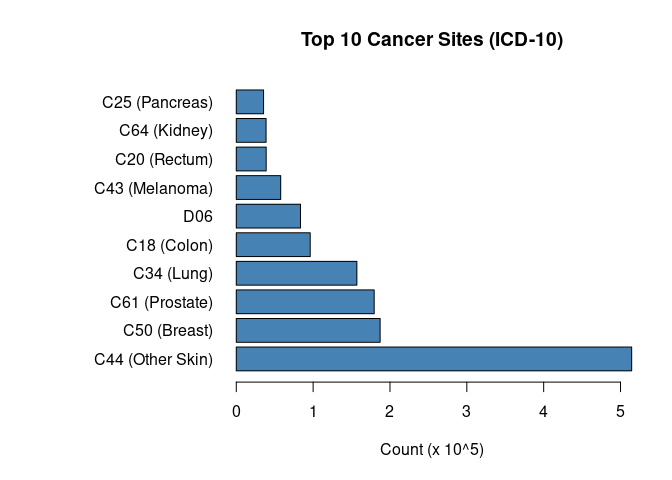

In [ ]:
# Helper function to map codes to names
icd10_map <- c(
  "C50" = "Breast", "C61" = "Prostate", "C34" = "Lung",
  "C18" = "Colon", "C19" = "Rectosigmoid", "C20" = "Rectum",
  "C43" = "Melanoma", "C44" = "Other Skin", "C67" = "Bladder",
  "C25" = "Pancreas", "C64" = "Kidney", "C90" = "Mult. Myeloma",
  "C92" = "Myeloid Leukemia", "D05" = "Carcinoma in situ (Breast)"
)

get_cancer_label <- function(code) {
  if (code %in% names(icd10_map)) {
    return(paste0(code, " (", icd10_map[code], ")"))
  } else {
    return(code)
  }
}

if("SITE_ICD10_O2" %in% names(df)) {
  # Create a new column with just the first 3 characters
  df$SITE_MAIN <- substr(df$SITE_ICD10_O2, 1, 3)
  
  # Count and sort
  site_counts <- sort(table(df$SITE_MAIN), decreasing = TRUE)
  top_10_sites <- head(site_counts, 10)
  
  # Prepare labels and scale counts for readability (x 10^5)
  labels <- sapply(names(top_10_sites), get_cancer_label)
  counts_scaled <- top_10_sites / 100000
  
  # Plot
  par(mar=c(5, 12, 4, 2) + 0.1) # Adjust margins for long labels
  barplot(counts_scaled, 
          main = "Top 10 Cancer Sites (ICD-10)",
          xlab = "Count (x 10^5)",
          names.arg = labels,
          col = "steelblue",
          horiz = TRUE,
          las = 1)
}

## Step 5.3: Analyze Stage Distribution

We analyze the `STAGE_BEST` column to see how many cancers are diagnosed
at early vs. late stages.

1.  **Count**: We count the unique values in `STAGE_BEST`.
2.  **Filter**: We focus on the most common stage codes.
3.  **Visualize**: We plot the distribution, adding a legend to explain
    the codes.

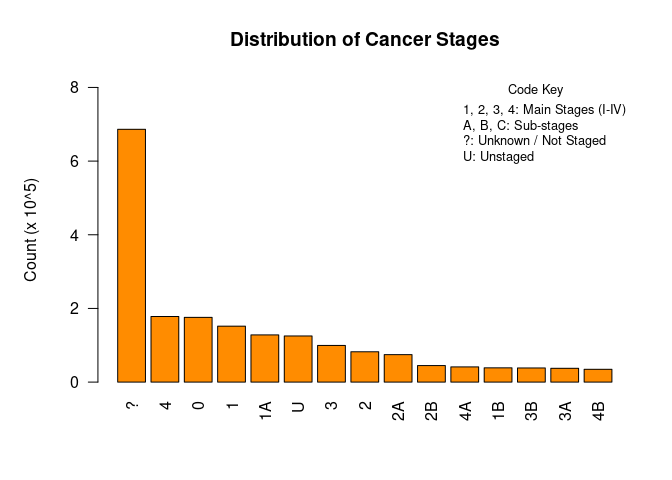

In [ ]:
stage_col <- NULL
if("STAGE_BEST" %in% names(df)) stage_col <- "STAGE_BEST"

if(!is.null(stage_col)) {
  # Count stages
  stage_counts <- table(df[[stage_col]])
  
  # Sort and take top 15 to avoid clutter
  stage_counts_sorted <- sort(stage_counts, decreasing = TRUE)
  top_stages <- head(stage_counts_sorted, 15)
  
  # Scale counts
  counts_scaled <- top_stages / 100000
  
  # Define legend text
  legend_text <- c(
    "1, 2, 3, 4: Main Stages (I-IV)",
    "A, B, C: Sub-stages",
    "?: Unknown / Not Staged",
    "U: Unstaged"
  )
  
  # Plot
  par(mar=c(5, 5, 4, 2) + 0.1)
  barplot(counts_scaled, 
          main = "Distribution of Cancer Stages",
          ylab = "Count (x 10^5)",
          col = "darkorange",
          las = 2,
          ylim = c(0, max(counts_scaled) * 1.2)) # Extra space for legend
  
  legend("topright", legend = legend_text, bty = "n", cex = 0.8, title = "Code Key")
}

# Conclusion

By following these steps, we have successfully: 1. Located and
understood the Simulacrum data. 2. Identified key columns for analysis.
3. Used R to visualize the prevalence of different cancers and their
staging at diagnosis.